<a href="https://colab.research.google.com/github/audachang/ML_collections/blob/main/face_attr_googlenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[ML collection using pytorch to predict category of custom dataset](https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/Basics/custom_dataset)

In [ ]:
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision

from sklearn.model_selection import KFold

import os
import pandas as pd
from PIL import Image
import seaborn as sns
import random
import matplotlib.pyplot as plt

import torchvision.models as models
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
)  # Gives easier dataset managment and creates mini batches

import os
import pandas as pd
import numpy as np


dpath = './drive/MyDrive/mycolab/data/'
model_path = './drive/MyDrive/mycolab/model/'
imgdir = os.path.join(dpath, '346faces_sameBG_grey_adjBright')
annote_file = './drive/MyDrive/mycolab/data/346faces_allData.csv'  # or whatever the path to the downloaded data is

### checking on column names

In [ ]:
 #   Sr：使用圖片像素亮度計算出的客觀臉孔對稱係數
 #   oAI：臉孔的不對稱指標（數值越大代表越不對稱），因為此項指標需要在臉孔上標記20個特徵點，因此又分為manual（手動選點）、Facemesh（使用Facemesh選點）
 #   prototypicality：有多像平均臉
 #   sensitivity、criterion ：臉孔辨識記憶的指標
 #   gray_att_upr：吸引力評分
 #   gray_sym_upr：對稱度評分

labdata = pd.read_csv(annote_file)
labels = labdata.iloc[:,[11,3]]

In [ ]:
labdata.columns

Index(['face', 'face_race', 'face_gender', 'image_grey_adj',
       'Sr_column_grey_adj', 'manual_oAI_raw', 'FaceMesh_oAI_raw',
       'FaceMesh_oAI_normalized', 'prototypicality.N.54.', 'sensitivity.N.56.',
       'criterion.N.56.', 'gray_att_upr', 'gray_sym_upr'],
      dtype='object')

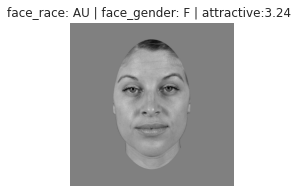

In [ ]:
random_imgfn = random.choice(labels.iloc[:,1])

img = Image.open(os.path.join(imgdir, random_imgfn ))
face_race = labdata.query(
    "image_grey_adj==@random_imgfn")["face_race"].item()

face_gender = labdata.query(
    "image_grey_adj==@random_imgfn")["face_gender"].item()

gray_att_upr = labdata.query(
    "image_grey_adj==@random_imgfn")["gray_att_upr"].item()

sns.set_theme()

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(4, 3))
plt.imshow(img_as_array)
plt.title(f"face_race: {face_race} | face_gender: {face_gender} | attractive:{gray_att_upr:.2f} ")
plt.axis(False);

## Reading structured data

In [ ]:
class faceDataset(Dataset):
    def __init__(self, csv_file, root_dir, tarlab, transform=None):
        self.annotations = pd.read_csv(csv_file)

        self.annotations['value'] = self.annotations[tarlab]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 3])
        image = Image.open(img_path)
        y_label = torch.tensor(self.annotations.loc[index, 'value'])
        y_label = y_label.float()
        #y_label = y_label.unsqueeze(1)

        if self.transform:
            image = self.transform(image)
            image = image.float()


        return (image, y_label)

## Setting up training parameters

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
learning_rate = 3e-4
batch_size = 32
num_epochs = 10

## Loading dataset

In [ ]:
IMAGE_WIDTH=480
IMAGE_HEIGHT=480
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to IMAGE_SIZE xIMAGE_SIZE 
    transforms.Resize(size=IMAGE_SIZE),
    # Flip the images randomly on the horizontal
    #transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

dataset = faceDataset(
    csv_file=annote_file,
    root_dir=imgdir,
    tarlab = 'gray_att_upr',
    transform=data_transform
)


In [ ]:
os.path.join(imgdir,labdata.image_grey_adj[2])

'./drive/MyDrive/mycolab/data/346faces_sameBG_grey_adjBright/AUF_11_squared_adjBright.png'

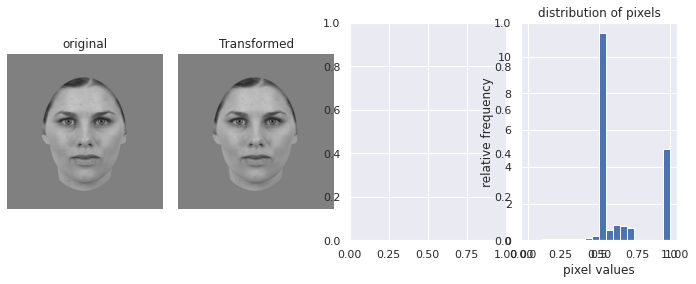

In [ ]:


fig, ax = plt.subplots(1, 4, figsize = (12,4))
# Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
gs = ax[2].get_gridspec()

ax[0].imshow(
    Image.open(os.path.join(imgdir,labdata.image_grey_adj[2])))

ax[0].axis('off')
ax[0].set_title("original")

ax[1].imshow(dataset[2][0].permute(1,2,0))
ax[1].axis('off')
ax[1].set_title("Transformed")

ax[2].axis('off')

ax[3].hist(dataset[0][0].ravel(), bins=20, density=True)
ax[3].set_xlabel("pixel values")
ax[3].set_ylabel("relative frequency")
ax[3].set_title("distribution of pixels")



# Show the plot
plt.show()

## Splitting test and training set

In [ ]:
# Train 跟 test 的大小
test_size = int(len(dataset)*0.2)
train_size = len(dataset)- int(len(dataset)*0.2)

# 切割資料集
train_dataset, test_dataset = \
  torch.utils.data.random_split(dataset, [train_size, test_size])

# 套上dataloader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

## initiate model
[googlenet](https://tigercosmos.xyz/post/2020/10/ai/googlenet/)

In [ ]:
# Define the GoogleNet regression model
class GoogleNetRegressor(nn.Module):
    def __init__(self):
        super(GoogleNetRegressor, self).__init__()
        self.googlenet = models.googlenet(weights='DEFAULT')
        self.googlenet.fc = nn.Linear(in_features=1024, out_features=1)
    
    def forward(self, x):
        x = self.googlenet(x)
        return x


def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for i, (images, targets) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, targets.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(images)
    avg_loss = total_loss / len(train_loader.dataset)
    return avg_loss

def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            outputs = model(images)
            loss = criterion(outputs, targets.unsqueeze(1))
            total_loss += loss.item() * len(images)
    avg_loss = total_loss / len(val_loader.dataset)
    return avg_loss


def test(model, test_loader):
    model.eval()  # switch to evaluation mode

    with torch.no_grad():
        total_loss = 0.0
        test_out = []
        for images, targets in test_loader:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, targets.unsqueeze(1))
            total_loss += loss.item() * len(images)
            predicted = list(itertools.chain.from_iterable(outputs.tolist()))
            target = list(itertools.chain.from_iterable([targets.tolist()])) # wrap targets in a list
            test_out.append((predicted, target))
        avg_loss = total_loss / len(test_loader.dataset)
        print('Test Loss: {:.4f}'.format(avg_loss))
        test_df = pd.DataFrame(test_out, columns=["Predicted", "Target"])
        test_df = test_df.apply(lambda x: x.apply(pd.Series).stack()).reset_index(drop=True)
        return test_df


def cross_validation(model, dataset, n_splits=5, epochs=10, model_path="models", model_name="model"):
    kf = KFold(n_splits=n_splits)
    
    criterion = nn.MSELoss()
    train_losses=[]
    val_losses = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"\n=== Fold {fold + 1}/{n_splits} ===")
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        best_val_loss = float("inf")
        
        for epoch in range(epochs):
            print(f"\n--- Epoch {epoch + 1}/{epochs} ---")
            train_loss = train(model, train_loader, criterion, optimizer)
            val_loss = validate(model, val_loader, criterion)
            
            print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print(f"Best validation loss of Fold {fold} so far is epoch {epoch}: {best_val_loss}")
                checkpoint_path = os.path.join(model_path, f"{model_name}-Fold{fold + 1}-Epoch{epoch + 1}.pth")
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch + 1
                }, checkpoint_path)
                print(f"Model saved at {checkpoint_path}")
        
        # collect the train_loss and val_loss of last epoch in each fold
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    print("Cross-validation training finished.")
    print(f"Average Train Loss: {np.mean(train_losses):.4f}, Std Dev: {np.std(train_losses):.4f}")
    print(f"Average Validation Loss: {np.mean(val_losses):.4f}, Std Dev: {np.std(val_losses):.4f}")


## Model training

In [ ]:
# Define the hyperparameters

model_name = 'model_googlenet_size480'
# Instantiate the GoogleNet regressor model, criterion, and optimizer
model = GoogleNetRegressor()

# Instantiate the GoogleNet regressor model
# Perform cross-validation
cross_validation(model, dataset, n_splits=5, epochs=num_epochs, 
                 model_path=model_path, model_name=model_name)




=== Fold 1/5 ===

--- Epoch 1/10 ---
Train Loss: 9.1536, Validation Loss: 4.0551
Model saved at ./drive/MyDrive/mycolab/model/model_googlenet_size480-Fold1-Epoch1.pth

--- Epoch 2/10 ---
Train Loss: 1.2668, Validation Loss: 0.5749
Model saved at ./drive/MyDrive/mycolab/model/model_googlenet_size480-Fold1-Epoch2.pth

--- Epoch 3/10 ---
Train Loss: 0.1250, Validation Loss: 0.6831

--- Epoch 4/10 ---
Train Loss: 0.0994, Validation Loss: 0.3119
Model saved at ./drive/MyDrive/mycolab/model/model_googlenet_size480-Fold1-Epoch4.pth

--- Epoch 5/10 ---
Train Loss: 0.1189, Validation Loss: 0.2229
Model saved at ./drive/MyDrive/mycolab/model/model_googlenet_size480-Fold1-Epoch5.pth

--- Epoch 6/10 ---
Train Loss: 0.0764, Validation Loss: 0.3757

--- Epoch 7/10 ---
Train Loss: 0.1032, Validation Loss: 0.2351

--- Epoch 8/10 ---
Train Loss: 0.0602, Validation Loss: 0.3193

--- Epoch 9/10 ---
Train Loss: 0.0497, Validation Loss: 0.2207
Model saved at ./drive/MyDrive/mycolab/model/model_googlenet_s

NameError: ignored

## Check accuracy on training data


- (optional) test with the loaded model

In [ ]:
import itertools


# Load the saved model
model_name = 'googlenet_pretrained-Final.pth'
checkpoint = torch.load(os.path.join(model_path, model_name))
model = GoogleNetRegressor()
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.Adam(model.parameters())
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']



Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

## Predicted vs. Traget values for trained data

Test Loss: 0.0262


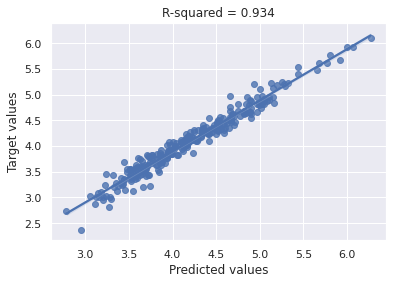

In [ ]:
import itertools

output_train = test(model, train_loader)
# Create a scatter plot with regression line and R-squared
sns.regplot(x=output_train.Predicted,y=output_train.Target)
plt.ylabel('Target values')
plt.xlabel('Predicted values')

# Calculate and display R-squared
from sklearn.metrics import r2_score
r_squared = r2_score(output_train.Predicted,output_train.Target)
plt.title(f"R-squared = {r_squared:.3f}")

plt.show()

## Plotting Predicted vs. Target values for testing data

Test Loss: 0.0225


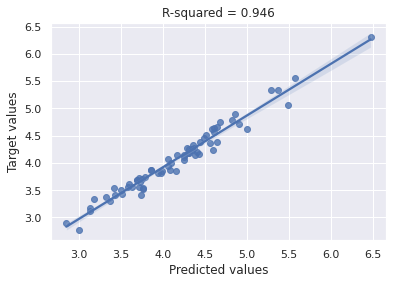

In [ ]:
output_test = test(model, test_loader)

# Create a scatter plot with regression line and R-squared
sns.regplot(x=output_test.Predicted,y=output_test.Target)
plt.ylabel('Target values')
plt.xlabel('Predicted values')

# Calculate and display R-squared
from sklearn.metrics import r2_score
r_squared = r2_score(output_test.Predicted,output_test.Target)
plt.title(f"R-squared = {r_squared:.3f}")

plt.show()

In [ ]:
# Define a function to show images
def show_images(images):
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(12, 3))
    for i, image in enumerate(images):
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].axis('off')
    plt.show()

# Iterate through the test loader and show images
for images, targets in test_loader:
    show_images(images)
    break  # Show only the first batch of images